<a href="https://colab.research.google.com/github/farhan1503001/Deep-Learning-Rhyme-Projects/blob/main/Person_Identification_Using_Siamese_Networks(Pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segementation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement segementation-models-pytorch (from versions: none)
ERROR: No matching distribution found for segementation-models-pytorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-5vv9h30j
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-5vv9h30j
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125709 sha256=fdcc4dbb1f8498bdb022570353429d1cec2eadc6a3ceabf1ba7e63f008b9e08c
  Stored in directory: /tmp/pip-ephem-wheel-cache-uvtx2w2h/wh

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 17.81 MiB/s, done.


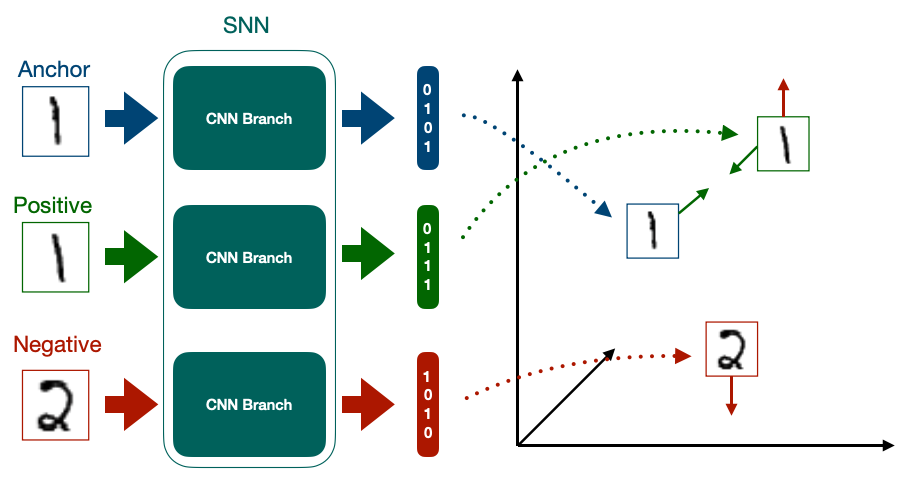

# Imports

**Defining the system path**

In [3]:
#Importing sys to define system's path
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

**Importing Necessary Libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [5]:
DATA_DIR='/content/Person-Re-Id-Dataset/train/'
CSV_PATH='/content/Person-Re-Id-Dataset/train.csv'
BATCH_SIZE=32
LR=0.001
EPOCHS=20
DEVICE='cuda'

**Reading the csv file using Pandas**

In [6]:
df=pd.read_csv(CSV_PATH)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


**Read 3 Sample image**

In [7]:
row=df.iloc[34]

a_img=io.imread(DATA_DIR+row.Anchor)
n_img=io.imread(DATA_DIR+row.Negative)
p_img=io.imread(DATA_DIR+row.Positive)

**Visualizing images**

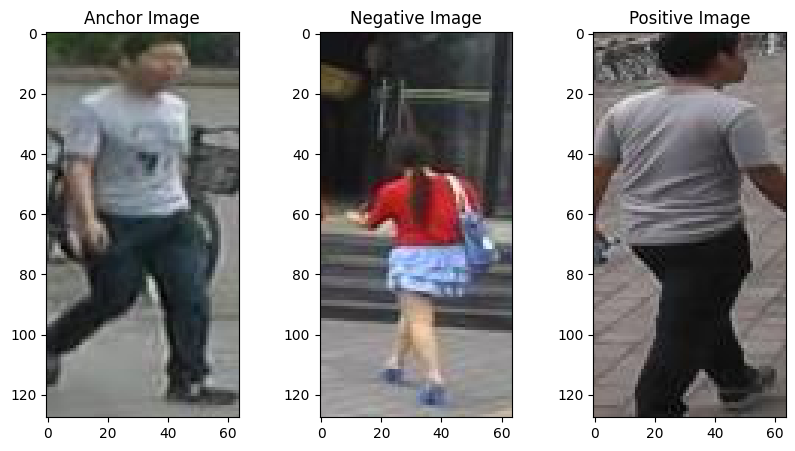

In [8]:
f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))

ax1.set_title("Anchor Image")
ax1.imshow(a_img)

ax2.set_title("Negative Image")
ax2.imshow(n_img)

ax3.set_title("Positive Image")
ax3.imshow(p_img)

In [9]:
train_df,valid_df=train_test_split(df,test_size=0.20,random_state=42)

# Create APN Dataset 

In [10]:
class APNDataset(Dataset):
  def __init__(self,df):
    self.df=df
  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row=self.df.iloc[idx]

    a_img=io.imread(fname=DATA_DIR+row.Anchor)
    n_img=io.imread(fname=DATA_DIR+row.Negative)
    p_img=io.imread(fname=DATA_DIR+row.Positive)
    #Now converting them from numpy array to tensor
    A_img=torch.from_numpy(a_img).permute(2,0,1)/255.0 #(h,w,c)->(c,h,w)
    N_img=torch.from_numpy(n_img).permute(2,0,1)/255.0
    P_img=torch.from_numpy(p_img).permute(2,0,1)/255.0

    return A_img,P_img,N_img


In [11]:
trainset=APNDataset(train_df)
validset=APNDataset(valid_df)

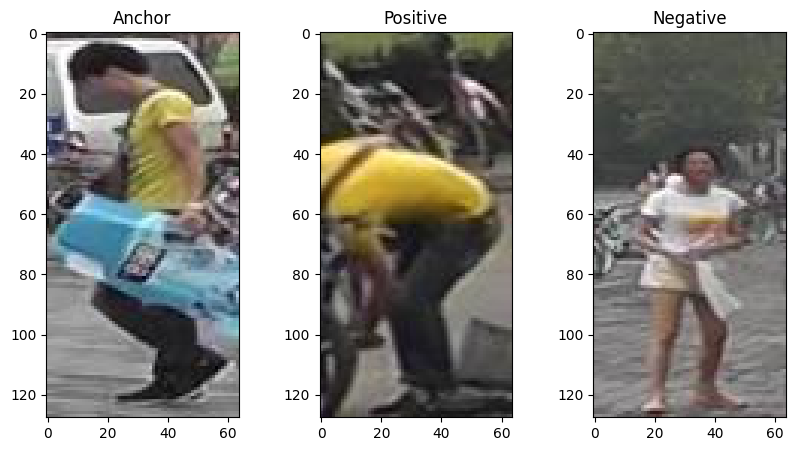

In [12]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [13]:
#Writing dataloaders for our task
trainloader=DataLoader(dataset=trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(dataset=validset,batch_size=BATCH_SIZE)

In [14]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [15]:
for A,P,N in trainloader:
  break
    
print(f"One image batch shape : {A.shape}")
print(f"One positive image batch shape: ",{P.shape})
print(f"One negative image batch shape: ",{N.shape})

One image batch shape : torch.Size([32, 3, 128, 64])
One positive image batch shape:  {torch.Size([32, 3, 128, 64])}
One negative image batch shape:  {torch.Size([32, 3, 128, 64])}


# Create Model 

In [18]:
class APNModel(nn.Module):
  def __init__(self,emb_size=512):
    super(APNModel,self).__init__()
    self.backbone=timm.create_model(model_name='efficientnet_b0',pretrained=True)
    self.backbone.classifier=nn.Linear(in_features=self.backbone.classifier.in_features,out_features=emb_size)

  def forward(self,images):
    embeddings=self.backbone(images)

    return embeddings


In [21]:
model=APNModel(emb_size=1024)
model.to(DEVICE);

# Create Train and Eval function

**Training Function Creation**

In [23]:
def train_function(model,dataloader,optimizer,criterion):
  #Initialize training
  model.train()
  total_loss=0.0
  for A,P,N in tqdm(dataloader):
    A,P,N=A.to(DEVICE),P.to(DEVICE),N.to(DEVICE)
    #Now finding embeddings
    A_emb=model(A)
    P_emb=model(P)
    N_emb=model(N)

    loss=criterion(A_emb,P_emb,N_emb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
  return total_loss/len(dataloader)

In [24]:
def eval_function(model,dataloader,criterion):
  model.eval()
  total_loss=0.0
  with torch.no_grad():
    for A,P,N in tqdm(dataloader):
      A,P,N=A.to(DEVICE),P.to(DEVICE),N.to(DEVICE)
      #Now finding embedding
      A_emb=model(A)
      P_emb=model(P)
      N_emb=model(N)
      #Finding loss
      loss=criterion(A_emb,P_emb,N_emb)
      total_loss+=loss.item()

    return total_loss/len(dataloader)

**Now setting up Optimizer and criterion**

In [26]:
criterion=nn.TripletMarginLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=LR)

# Create Training Loop

In [27]:
best_valid_loss=np.Inf
for i in range(EPOCHS):
  train_loss=train_function(model,trainloader,optimizer,criterion)
  valid_loss=eval_function(model,validloader,criterion)

  if best_valid_loss>valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    best_valid_loss=valid_loss
    print("Best Model Has Been Saved")
  print(f"Epochs: {i+1}/{EPOCHS}: Train Loss: {train_loss} Valid Loss: {valid_loss}")

100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


Best Model Has Been Saved
Epochs: 1/20: Train Loss: 0.6968100050091743 Valid Loss: 0.6371852624416351


100%|██████████| 25/25 [00:02<00:00,  8.54it/s]


Best Model Has Been Saved
Epochs: 2/20: Train Loss: 0.32472110509872437 Valid Loss: 0.3860171675682068


100%|██████████| 25/25 [00:02<00:00,  9.70it/s]


Best Model Has Been Saved
Epochs: 3/20: Train Loss: 0.2098299026489258 Valid Loss: 0.28148417949676513


100%|██████████| 25/25 [00:02<00:00, 10.28it/s]


Best Model Has Been Saved
Epochs: 4/20: Train Loss: 0.12001155987381935 Valid Loss: 0.21758946239948274


100%|██████████| 25/25 [00:02<00:00,  9.99it/s]


Best Model Has Been Saved
Epochs: 5/20: Train Loss: 0.07662353739142418 Valid Loss: 0.1955408489704132


100%|██████████| 25/25 [00:02<00:00,  9.51it/s]


Best Model Has Been Saved
Epochs: 6/20: Train Loss: 0.05699971273541451 Valid Loss: 0.1832367956638336


100%|██████████| 25/25 [00:02<00:00,  9.08it/s]


Epochs: 7/20: Train Loss: 0.08332181945443154 Valid Loss: 0.22183764964342118


100%|██████████| 25/25 [00:02<00:00,  9.46it/s]


Best Model Has Been Saved
Epochs: 8/20: Train Loss: 0.07237440779805183 Valid Loss: 0.1522977429628372


100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


Epochs: 9/20: Train Loss: 0.04685333326458931 Valid Loss: 0.18274608731269837


100%|██████████| 25/25 [00:02<00:00,  8.59it/s]


Epochs: 10/20: Train Loss: 0.03140954658389092 Valid Loss: 0.1594123649597168


100%|██████████| 25/25 [00:02<00:00,  9.94it/s]


Epochs: 11/20: Train Loss: 0.0614610955119133 Valid Loss: 0.16590283036231995


100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Best Model Has Been Saved
Epochs: 12/20: Train Loss: 0.0543876663595438 Valid Loss: 0.10166823208332061


100%|██████████| 25/25 [00:02<00:00,  9.96it/s]


Best Model Has Been Saved
Epochs: 13/20: Train Loss: 0.037388075813651084 Valid Loss: 0.09535561978816987


100%|██████████| 25/25 [00:02<00:00,  8.38it/s]


Epochs: 14/20: Train Loss: 0.019866693168878555 Valid Loss: 0.1169746881723404


100%|██████████| 25/25 [00:02<00:00,  9.85it/s]


Epochs: 15/20: Train Loss: 0.029891549944877624 Valid Loss: 0.13374651074409485


100%|██████████| 25/25 [00:02<00:00, 10.19it/s]


Epochs: 16/20: Train Loss: 0.018603524714708327 Valid Loss: 0.11136227548122406


100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Epochs: 17/20: Train Loss: 0.038200266659259796 Valid Loss: 0.1829829430580139


100%|██████████| 25/25 [00:03<00:00,  7.60it/s]


Epochs: 18/20: Train Loss: 0.043110352009534836 Valid Loss: 0.1299784767627716


100%|██████████| 25/25 [00:02<00:00,  9.83it/s]


Epochs: 19/20: Train Loss: 0.060761931389570235 Valid Loss: 0.29248813033103943


100%|██████████| 25/25 [00:02<00:00,  9.55it/s]

Epochs: 20/20: Train Loss: 0.06530139341950417 Valid Loss: 0.1467599380016327


# Get Anchor Embeddings

In [33]:
#Now we will try to save encodings in a separate csv file
def encoding_csv(model,anc_img_names):
  anc_image_arr_names=np.array(anc_img_names)
  encodings=[]
  model.eval()
  with torch.no_grad():
    for img_p in tqdm(anc_image_arr_names):
      A=io.imread(DATA_DIR+img_p)
      A=torch.from_numpy(A).permute(2,0,1)/255.0
      A=A.to(DEVICE)
      #Now finding encoding
      A_emb=model(A.unsqueeze(0))
      encodings.append(A_emb.squeeze().cpu().detach().numpy())
    encodings=np.array(encodings)
    encodings=pd.DataFrame(encodings)
    df_enc=pd.concat([anc_img_names,encodings],axis=1)

  return df_enc

In [34]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc=encoding_csv(model,df['Anchor'])

100%|██████████| 4000/4000 [00:42<00:00, 93.09it/s]


**Saving as CSV FILE**

In [36]:
df_enc.to_csv('database.csv',index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,1420_c5s3_052165_01.jpg,0.177915,0.861486,0.702448,0.071177,-0.107433,0.197521,-0.058815,-0.204670,0.078340,...,-0.015965,-0.377106,0.180529,0.518538,0.502033,-0.126635,0.013356,-0.029121,0.724634,0.373397
1,1420_c3s3_061978_03.jpg,0.340631,0.881035,0.736390,0.104950,0.011779,0.287011,0.116819,0.013348,-0.177511,...,0.160248,-0.203355,0.181876,0.496409,0.560940,-0.325254,-0.042160,-0.058361,0.618052,0.361169
2,1420_c5s3_062565_05.jpg,0.275035,0.875648,0.435339,0.138617,-0.201971,0.237882,-0.385414,-0.418772,0.032198,...,-0.154526,-0.090315,-0.063286,0.277128,0.602027,-0.337058,-0.042765,-0.128587,0.777648,0.108959
3,1420_c6s3_085592_04.jpg,0.810212,0.963941,0.684475,0.176034,-0.033168,0.691313,-0.222660,0.014647,-0.233870,...,0.018277,-0.239118,0.663582,0.405872,0.543092,-0.336943,-0.172270,-0.094788,0.807062,0.002691
4,0663_c5s3_085987_03.jpg,0.455892,0.199427,-0.733272,0.700130,-0.198273,0.059827,-0.117140,-0.096450,-0.038395,...,-0.393388,-0.043872,-0.051739,-0.273415,0.081491,0.273162,-0.512444,0.309927,0.121659,-0.493445


# Inference

**Function for finding encoding**

In [37]:
def euclidian_dist(img_enc,anc_enc_arr):
  dist=np.sqrt(np.dot((img_enc-anc_enc_arr),(img_enc-anc_enc_arr).T))
  return dist

In [38]:
#Now we will read a image and find it's encoding 
idx=0
#Find image name
img_name=df_enc['Anchor'].iloc[idx]
img_path=DATA_DIR+img_name

image=io.imread(img_path)
image=torch.from_numpy(image).permute(2,0,1)/255.0
model.eval()

with torch.no_grad():
  image=image.to(DEVICE)
  image_enc=model(image.unsqueeze(0))
  image_enc=image_enc.detach().cpu().numpy()
  

In [39]:
anc_enc_arr=df_enc.iloc[:,1:].to_numpy()
anc_img_names=df_enc['Anchor']

In [40]:
distances=[]
for i in range(anc_enc_arr.shape[0]):
  dist=euclidian_dist(image_enc,anc_enc_arr[i:i+1,:])
  distances=np.append(distances,dist)


In [41]:
closest_idx=np.argsort(distances)

/usr/local/lib/python3.9/dist-packages/networkx/drawing/layout.py:726: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


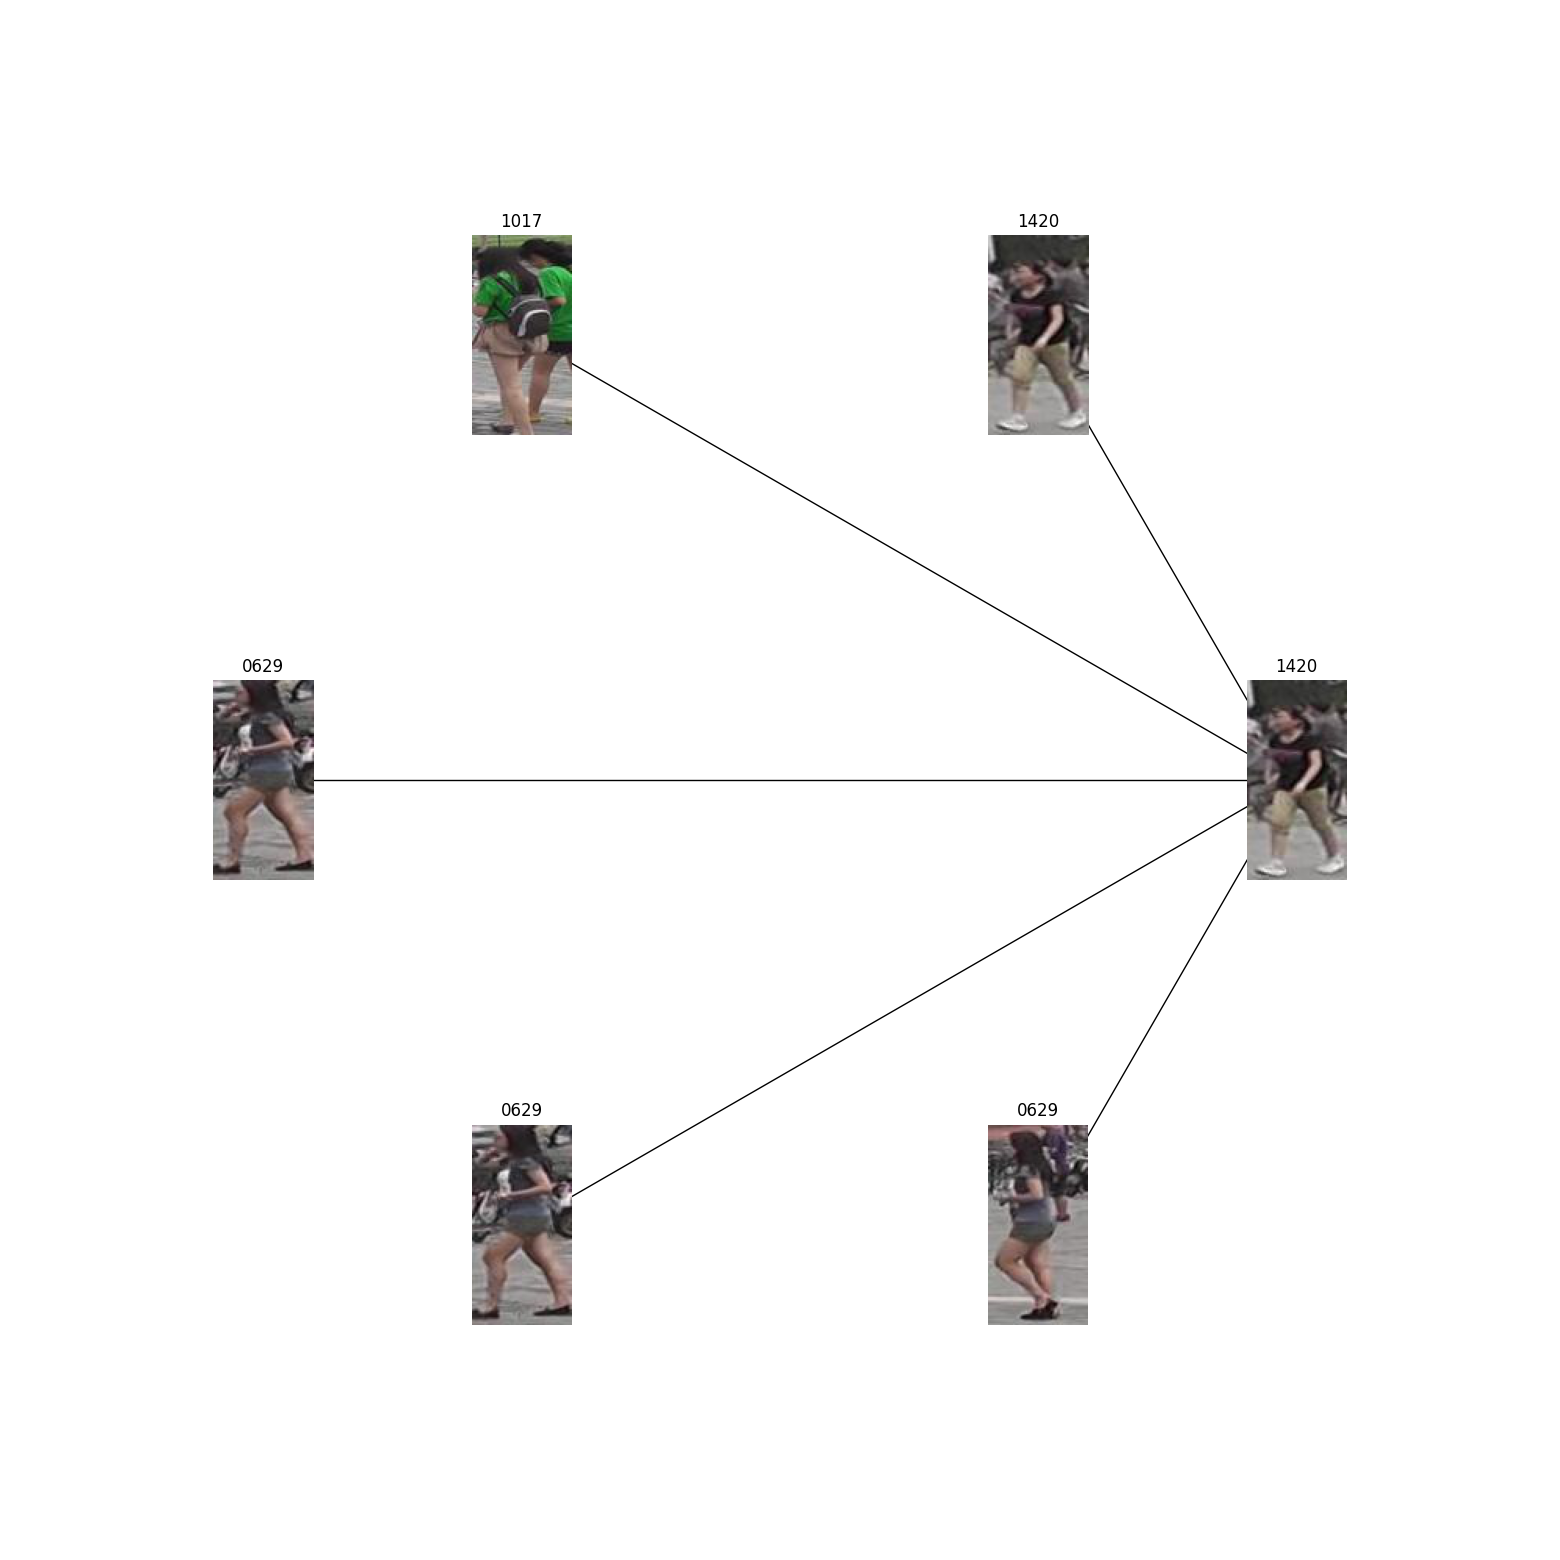

In [42]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, image, img_path, closest_idx, distances, no_of_closest = 5);